In [2]:
2+2

4

## RIVERS-PILOT EXPERIMENT OVERVIEW

    The rivers-pilot project runs the realistic SSC, v201812 (good bloom timing), from the following run directory:
        SS-run-sets/SalishSea/nemo3.6/tereza/RIVERS/RIVERS_pilot
        
    Restarts are from /results/SalishSea/nowcast-green.201812/31dec16
    
    There are two run scenarios, base and SHIFT, which use identical namelist.times and have the following diff patterns per yamls (base v SHIFT):
                < run_id: RP_base_1
            ---
            > run_id: RP_base_1_SHIFT
            20c20
            <     link to: $PROJECT/tjarnik/MEOPAR/RIVERS_files/daily_R201702/
            ---
            >     link to: $PROJECT/tjarnik/MEOPAR/RIVERS_files/daily_45Dearly/
            54c54
            <   - ./namelist.atmos_rivers
            ---
            >   - ./namelist.atmos_riversSHIFT
            
    The RIVERS_files are made in: 
        notebooks/RIVER_PAPER/RIVERS_pilot/make_daily_files and make_daily_files_shifted_hydrograph
    These use daily interpolated values from monthly averages, for all rivers except the fraser, where realistic 2017 values are used. 
    
    Then we shift the 'glacial' watersheds, as well as the Fraser river, forward 45 days to examine effects. 
        (not the rest of the fraser watershed; this is because Tereza forgot. 
        Not really a problem though, for a pilot run)
    The glacial watersheds are: wat_to_rot = ['skagit', 'howe', 'bute', 'toba']
    
    Results are stored in: /data/tjarniko/results/RIV_PIL
    
## NOTEBOOK OVERVIEW

    1. Here we first visualize the rivers in the SalishSeaCast model by watershed. 
    
    2. We then look at hydrograph patterns by watershed, identifying 
    the largest 5 rivers in each watershed by runoff.
    
    3. We then introduce the river_acid_observatory tool, which shows the hydgrograph of each river of interest 
    as well as key inorg. C cycle variables in the vicinity of its mouth: 
    S, nitrate, diatoms, TA-DIC, DIC, nDIC, and Omega.
    We consider two radii of importance: 3 grid cells from river mouth (~1.5 km) and 10 grid cells (5 km)
    The exception is the Fraser, where we have to consider a point not at the river mouth. 
    
    4. We apply the river_acid_observatory tool to the largest river in each watershed, 
    for both the BASE and the SHIFT runs. 
    
    5. We also build a river_flux_observatory tool, which shows the hydrograph of each river of interest 
    as well as key carbon air-sea flux variables in the vicinity of its mouth:  
    pCO2, delta-pCO2, wind strength, and flux. We apply this to the largest rivers in the watershed as well. 
    

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
import sys
import numpy as np
import netCDF4 as nc
import cmocean as cm
import matplotlib.pyplot as plt
import pickle
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)
sys.path.append('/data/tjarniko/mocsy')
import mocsy
import arrow
import gsw
import glob
sys.path.append('/data/tjarniko/MEOPAR/tools/SalishSeaTools/salishsea_tools/')

import river_201702 as rv

## watershed map

In [5]:
def wshed_plot(surfdat_1,tit1,t_cmap,xsize,ysize,v_min1,v_max1,cl1,bigtit):
    "TESTED"

    fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize), sharey=True)
    cmap = t_cmap
            

    tplt = np.ma.masked_values(surfdat_1,0)
    ax.set_title(tit1,fontsize = 20 )
    v_min = v_min1
    v_max = v_max1
    clabel = cl1

    viz_tools.set_aspect(ax)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=v_min, vmax=v_max) 
    ax.set_xlabel('x Index', fontsize = 20 )
    ax.set_ylabel('y Index', fontsize = 20 )
    

    watersheds = rv.prop_dict.keys()
    #watershed counter
    wc = 0
    tr = 0
    wsl = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
    for watshed in watersheds:
        #print(watshed)
        rivs = rv.prop_dict[watshed].keys()
        #river counter for index
        rc = 0
        for riv in rivs:

            ti = rv.prop_dict[watshed][riv]['i']
            tj = rv.prop_dict[watshed][riv]['j']
            if rc==0: 
                pts = ax.scatter(tj,ti,s=30,c=cols[wc],label = wsl[wc],marker='o')
                
            else:
                pts = ax.scatter(tj,ti,s=30,c=cols[wc],marker='o')
                
            ax.text(tj+5,ti,riv, weight = 'bold', fontsize = 10)
            
#             samprivs = ['SanJuan', 'Skagit1', 'Puyallup', 'Nanaimo1', 'Homathko', 'Toba', 'Squamish', 'Englishman'] #samprivs = []
#             if riv in samprivs:
#                 ax.text(tj+5,ti,riv, weight = 'bold', fontsize = 14)

            rc = rc+1
            tr = tr+1
        wc = wc+1
    
    ax.scatter(300,425,s=100,c='k',label = 'Fraser-obs?',marker='*')
   

    plt.xlim([0,398])
    plt.ylim([0,898])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    cmap.set_bad('lightslategray')
    plt.legend(bbox_to_anchor=(1.29, 0.95))
    plt.suptitle(bigtit,fontsize=20)

In [6]:

watersheds = rv.prop_dict.keys()
riv_i = []
riv_j = []
riv_shed = []
riv_name = []
i = 0
for watshed in watersheds:
    #print('~~')
    rivs = rv.prop_dict[watshed].keys()
    for riv in rivs:
        #print('Riv: '+riv+', watershed: '+watshed)
        #swap is, js here
        ti = rv.prop_dict[watshed][riv]['j']
        tj = rv.prop_dict[watshed][riv]['i']
        riv_i.append(ti)
        riv_j.append(tj)
        riv_shed.append(watshed)
        riv_name.append(riv)
        i = i+1


gauge_riv = ['Squamish','SanJuan','Elwha','DungenessMatriotti','Hoko','LittleBigQuilcene',\
            'Duckabush','Skokomish','DeerJohnsGoldboroughMill','Deschutes','Chambers',\
            'Chambers','NisquallyMcAllister','Puyallup','CedarSammamish','Skagit1',\
            'Samish','Stillaguamish1','SnohomishAllenQuilceda','Tulalip','Mission',\
            'Nooksack','Fraser','Oyster','Qunisam','SalmonSayward','Theodosia',
             'Homathko','Cowichan1','Chemanius1','Nanaimo1','Englishman',
             'LittleQualicum','Puntledge']

cols = ['darkgray','red','powderblue','tan','orange',\
    'navy','palegreen','mediumaquamarine','dodgerblue','violet']
watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

# Rivers in the SKOG model

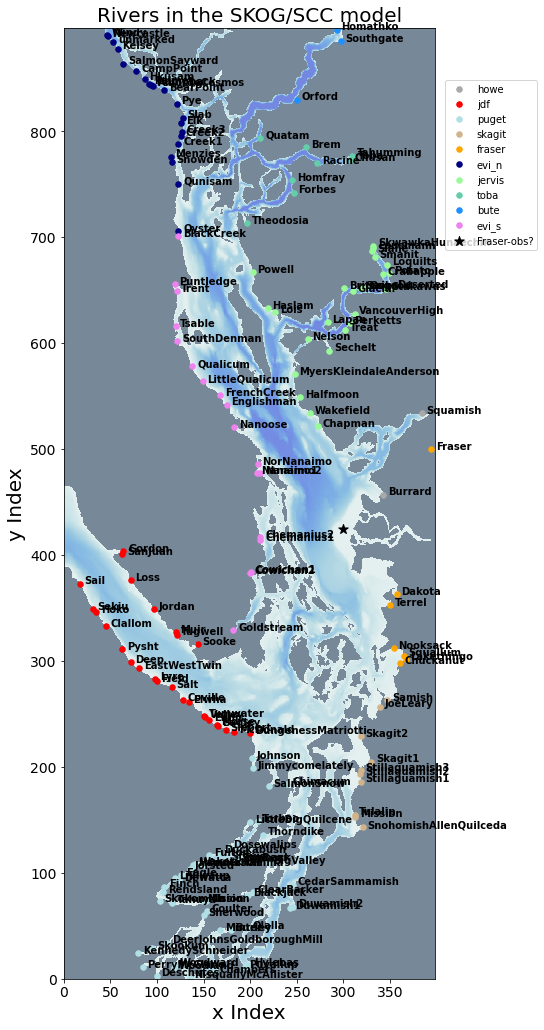

In [7]:
fact = 0.7
bath = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
bath1 = bath.variables['Bathymetry']
wshed_plot(bath1,'Rivers in the SKOG/SCC model', \
               cm.cm.dense,15*fact,25*fact,0,1000,'bathymetry','')

### calculate runoffs

In [8]:
import pickle
#pickle.dump(hydro_old_Fraser, open("hydroFraser_2017real.pkl", 'wb'))
hydroFraser_2017real = pickle.load(open('./hydroFraser_2017real.pkl', 'rb'))  

climatology_file = \
nc.Dataset('/data/tjarniko/MEOPAR/rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc')

import copy
clim_dict = copy.deepcopy(rv.prop_dict)
grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
wat_to_rot = ['skagit', 'howe', 'bute', 'toba']
for w in watersheds:
    interp_clim = climatology_file[w][:]

    #print(w)
    #print(interp_clim)
    rivers = (rv.prop_dict[w].keys())
    for r in rivers:
        #print(r)
        prop_wshed = rv.prop_dict[w][r]['prop']
        clim_dict[w][r]['interp_clim'] = prop_wshed * interp_clim
        river_i = rv.prop_dict[w][r]['j']
        river_j = rv.prop_dict[w][r]['i']
        river_dj = rv.prop_dict[w][r]['di']
        river_di = rv.prop_dict[w][r]['dj']
        area = grid['e1t'][0,river_j,river_i]*grid['e2t'][0,river_j,river_i]
        clim_dict[w][r]['interp_clim_modunits'] = prop_wshed * interp_clim / area * 1000
        clim_dict[w][r]['interp_clim_modunits_SHIFT'] = prop_wshed * interp_clim / area * 1000
        if w in wat_to_rot:
            clim_dict[w][r]['interp_clim_modunits_SHIFT'] = np.roll((prop_wshed * interp_clim / area * 1000),-45) 
        
        
        
        if ((w == 'fraser') & (r == 'Fraser')):
            clim_dict[w][r]['interp_clim_modunits'] = hydroFraser_2017real
            clim_dict[w][r]['interp_clim_modunits_SHIFT'] = np.roll(hydroFraser_2017real,-45)
            
            
            

## watersheds of the model, with 5 largest rivers labeled

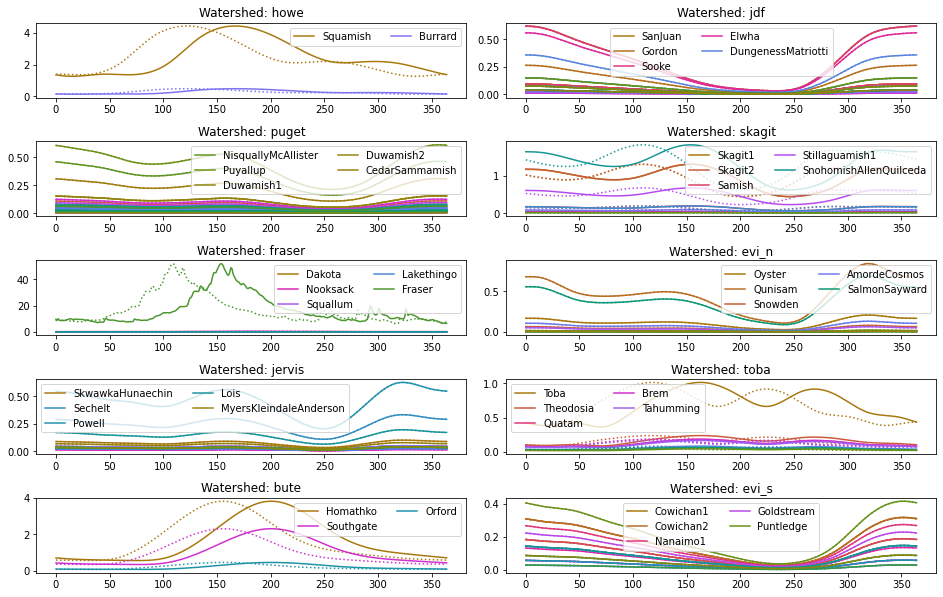

In [9]:
cmap = cm.cm.phase  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]


watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#911eb4',\
        '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',\
         '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000',\
        '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000',
       'black','mediumseagreen','olivedrab','yellow','saddlebrown']


fact = 0.6

fig = plt.figure(figsize=(22*fact,14*fact))
for i in range(1,11):
    
    ax = fig.add_subplot(5,2,i)
    w = watersheds[i-1]
    rivs = (clim_dict[w].keys())
        
        #sort rivers highest to smallest and get top 5 rivers, only label those
    rivlist = list(rivs)
    runlist = []

    for riv in rivs:
        maxrun = np.max(clim_dict[w][riv]['interp_clim_modunits'])
        runlist.append(maxrun)

    runar = np.array(runlist)
    rivar = np.array(rivlist)
    inds = runar.argsort()[::-1]
    sortriv = rivar[inds]
    biggest_riv = (sortriv[0:5])
    #print(biggest_riv)
    count = 0 
    numriv = np.size(rivlist)
    for riv in rivs:
        
        if riv in (biggest_riv):
            #yrprop = int((yr-1963) /(2018-1963) * 256)
            #print(int(count/numriv * 256))
            ax.plot(clim_dict[w][riv]['interp_clim_modunits'], label = riv, color = cmaplist[int(count/numriv * 256)], linewidth = 1.5)
        else:
            ax.plot(clim_dict[w][riv]['interp_clim_modunits'], color = cmaplist[int(count/numriv * 256)], linewidth = 1.5)
        ax.plot(clim_dict[w][riv]['interp_clim_modunits_SHIFT'], linestyle = ':', color = cmaplist[int(count/numriv * 256)], linewidth = 1.5)
        count = count+1
    ax.legend(ncol = 2, loc = 'best')
    ax.set_title('Watershed: '+ w, fontsize = 12)
   

plt.tight_layout()

### watersheds of the model, showing only the top 5 rivers in each watershed

howe
['Squamish' 'Burrard']
jdf
['SanJuan' 'Sooke' 'Elwha' 'DungenessMatriotti' 'Gordon']
puget
['Puyallup' 'NisquallyMcAllister' 'CedarSammamish' 'Duwamish2' 'Duwamish1']
skagit
['SnohomishAllenQuilceda' 'Skagit2' 'Skagit1' 'Stillaguamish1' 'Samish']
fraser
['Fraser' 'Nooksack' 'Dakota' 'Lakethingo' 'Squallum']
evi_n
['Qunisam' 'SalmonSayward' 'Oyster' 'AmordeCosmos' 'Snowden']
jervis
['Powell' 'Sechelt' 'Lois' 'SkwawkaHunaechin' 'MyersKleindaleAnderson']
toba
['Toba' 'Theodosia' 'Brem' 'Quatam' 'Tahumming']
bute
['Homathko' 'Southgate' 'Orford']
evi_s
['Puntledge' 'Cowichan1' 'Cowichan2' 'Nanaimo1' 'Goldstream']


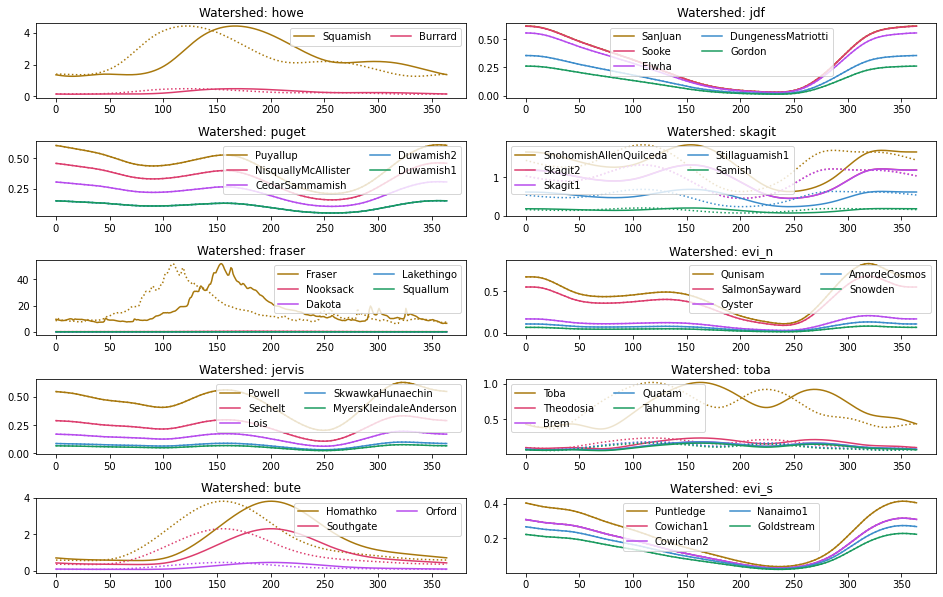

In [10]:
watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

fact = 0.6

fig = plt.figure(figsize=(22*fact,14*fact))
for i in range(1,11):
    
    ax = fig.add_subplot(5,2,i)
    w = watersheds[i-1]
    rivs = (clim_dict[w].keys())
        
        #sort rivers highest to smallest and get top 5 rivers, only label those
    rivlist = list(rivs)
    runlist = []

    for riv in rivs:
        maxrun = np.max(clim_dict[w][riv]['interp_clim_modunits'])
        runlist.append(maxrun)

    runar = np.array(runlist)
    rivar = np.array(rivlist)
    inds = runar.argsort()[::-1]
    sortriv = rivar[inds]
    biggest_riv = (sortriv[0:5])
    print(w)
    print(biggest_riv)
    count = 0
    for riv in biggest_riv:
       
        #if riv in (biggest_riv):
        #print(count)
        #print(int(count/5 * 256))
        ax.plot(clim_dict[w][riv]['interp_clim_modunits'], label = riv, color = cmaplist[int(count/5 * 256)])
        ax.plot(clim_dict[w][riv]['interp_clim_modunits_SHIFT'], linestyle = ':', color = cmaplist[int(count/5 * 256)])
        count = count+1

    ax.legend(ncol = 2, loc = 'best')
    ax.set_title('Watershed: '+ w, fontsize = 12)

plt.tight_layout()

## extraction functions for rivers (extract_ts_BASE and extract_ts_SHIFT)

In [11]:
rv.prop_dict['jdf']['SanJuan']['j']

63

In [12]:
rv.prop_dict['howe']['Squamish']['j']


384

In [13]:
rv.prop_dict['howe']['Squamish']['i']

534

In [14]:
def extract_ts_faaak(start,end,vartyp,varnam,j,i,rad, tdir):

    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):

        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        #tdir = '/data/tjarniko/results/FUTURE_runs/NEWBUDGET/*_RIVTA5/'
        guess = '*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = w[0]
        #print(w)
        if i%50 == 0:
            print(ymd)
        tnc = nc.Dataset(w)
        rivmouth = (tnc[varnam][0,0:5,tj-rad:tj+rad+1,ti-rad:ti+rad+1])
        rivmouth[rivmouth == 0] = np.nan
        ts[i] = np.nanmean(rivmouth)
    
    return ts

def extract_ts_faaak_surf(start,end,vartyp,varnam,j,i,rad, tdir):

    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):

        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        #tdir = '/data/tjarniko/results/FUTURE_runs/NEWBUDGET/*_RIVTA5/'
        guess = '*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = w[0]
        #print(w)
        if i%50 == 0:
            print(ymd)
        tnc = nc.Dataset(w)
        rivmouth = (tnc[varnam][0,tj-rad:tj+rad+1,ti-rad:ti+rad+1])
        rivmouth[rivmouth == 0] = np.nan
        ts[i] = np.nanmean(rivmouth)
    
    return ts


In [15]:
# w = nc.Dataset('/data/tjarniko/results/RIV_PIL/BASE/ncs/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170827-20170827.nc')

# print(w)

### calculate important properties for a given river and store in a dict.


In [16]:
# start ='2017-01-01'
# end ='2017-12-31'

# appendix = '_RIV3_SHIFT_20170101_20171231'

# # watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
# #               'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
# mainrivlist = ['Homathko','Squamish', 'Fraser']

# tjs = [896, 534, 425]
# tis = [293, 384, 300]

# # Squampton 384, 534
# # Homathko 293, 896
# # Fraser 180, 400



# for i in range(2,3):
#     tj = tjs[i]
#     ti = tis[i]
#     triv = mainrivlist[i] 
#     print(triv)
    
#     tdir = '/data/tjarniko/results/FUTURE_runs/RIVER_3/*_RIVTA5/'
#     appendix = '_RIV3_SHIFT_20170101_20171231'
#     pklnam = triv + appendix + '.pkl'
#     tr_dict = {}
#     rad = 10 
#     vartyp = 'grid_T'; varnam = 'vosaline'
#     tr_dict['sal_rad10'] = extract_ts_faaak(start,end,vartyp,varnam,tj,ti,rad, tdir)
#     vartyp = 'grid_T'; varnam = 'votemper'
#     tr_dict['temp_rad10'] = extract_ts_faaak(start,end,vartyp,varnam,tj,ti,rad, tdir)
#     vartyp = 'carp_T'; varnam = 'dissolved_inorganic_carbon'
#     tr_dict['DIC_rad10'] = extract_ts_faaak(start,end,vartyp,varnam,tj,ti,rad, tdir)
#     vartyp = 'carp_T'; varnam = 'total_alkalinity'
#     tr_dict['TA_rad10'] = extract_ts_faaak(start,end,vartyp,varnam,tj,ti,rad, tdir)
#     vartyp = 'ptrc_T'; varnam = 'nitrate';
#     tr_dict['nit_rad10'] = extract_ts_faaak(start,end,vartyp,varnam,tj,ti,rad, tdir)
#     vartyp = 'ptrc_T'; varnam = 'diatoms';
#     tr_dict['diat_rad10'] = extract_ts_faaak(start,end,vartyp,varnam,tj,ti,rad, tdir)
#     vartyp = 'carp_T'; varnam = 'co2_flux_mmol_m2_s'
#     tr_dict['co2flux_rad10'] = extract_ts_faaak_surf(start,end,vartyp,varnam,tj,ti,rad, tdir)
#     pickle.dump(tr_dict, open(pklnam, 'wb'))

#     tdir = '/data/tjarniko/results/FUTURE_runs/NEWBUDGET/*_RIVTA5/'
#     appendix = '_BASE_SHIFT_20170101_20171231'
#     pklnam = triv + appendix + '.pkl'
#     tr_dict = {}
#     rad = 10 
#     vartyp = 'grid_T'; varnam = 'vosaline'
#     tr_dict['sal_rad10'] = extract_ts_faaak(start,end,vartyp,varnam,tj,ti,rad, tdir)
#     vartyp = 'grid_T'; varnam = 'votemper'
#     tr_dict['temp_rad10'] = extract_ts_faaak(start,end,vartyp,varnam,tj,ti,rad, tdir)
#     vartyp = 'carp_T'; varnam = 'dissolved_inorganic_carbon'
#     tr_dict['DIC_rad10'] = extract_ts_faaak(start,end,vartyp,varnam,tj,ti,rad, tdir)
#     vartyp = 'carp_T'; varnam = 'total_alkalinity'
#     tr_dict['TA_rad10'] = extract_ts_faaak(start,end,vartyp,varnam,tj,ti,rad, tdir)
#     vartyp = 'ptrc_T'; varnam = 'nitrate';
#     tr_dict['nit_rad10'] = extract_ts_faaak(start,end,vartyp,varnam,tj,ti,rad, tdir)
#     vartyp = 'ptrc_T'; varnam = 'diatoms';
#     tr_dict['diat_rad10'] = extract_ts_faaak(start,end,vartyp,varnam,tj,ti,rad, tdir)
#     vartyp = 'carp_T'; varnam = 'co2_flux_mmol_m2_s'
#     tr_dict['co2flux_rad10'] = extract_ts_faaak_surf(start,end,vartyp,varnam,tj,ti,rad, tdir)
#     pickle.dump(tr_dict, open(pklnam, 'wb'))

        
        

In [17]:
import pickle
#pickle.dump(hydro_old_Fraser, open("hydroFraser_2017real.pkl", 'wb'))
hydroFraser_2017real = pickle.load(open('./hydroFraser_2017real.pkl', 'rb'))  

climatology_file = \
nc.Dataset('/data/tjarniko/MEOPAR/rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc')

import copy
clim_dict = copy.deepcopy(rv.prop_dict)
grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
wat_to_rot = ['skagit', 'howe', 'bute', 'toba']


wshed_tot = np.zeros([10,365])
i = 0 

for w in watersheds:
    interp_clim = climatology_file[w][:]

    #print(w)
    #print(interp_clim)
    rivers = (rv.prop_dict[w].keys())
    for r in rivers:
        #print(r)
        prop_wshed = rv.prop_dict[w][r]['prop']
        clim_dict[w][r]['interp_clim'] = prop_wshed * interp_clim
        river_i = rv.prop_dict[w][r]['j']
        river_j = rv.prop_dict[w][r]['i']
        river_dj = rv.prop_dict[w][r]['di']
        river_di = rv.prop_dict[w][r]['dj']
        depth = rv.prop_dict[w][r]['depth']
        area = grid['e1t'][0,river_j,river_i]*grid['e2t'][0,river_j,river_i]*river_dj*river_di
        clim_dict[w][r]['interp_clim_modunits'] = prop_wshed * interp_clim / area * 1000
        clim_dict[w][r]['interp_clim_modunits_SHIFT'] = prop_wshed * interp_clim / area * 1000
        wshed_tot[i,:] = wshed_tot[i,:] + clim_dict[w][r]['interp_clim'][:]
        if w in wat_to_rot:
            clim_dict[w][r]['interp_clim_modunits_SHIFT'] = np.roll((prop_wshed * interp_clim / area * 1000),-45) 
        
        

        
        if ((w == 'fraser') & (r == 'Fraser')):
            print(river_dj*river_di*depth)
            #print(clim_dict[w][r])
            clim_dict[w][r]['interp_clim_modunits'] = hydroFraser_2017real
            clim_dict[w][r]['interp_clim'] = hydroFraser_2017real /1000 * area 
#             print(clim_dict[w][r]['interp_clim'])
#             clim_dict[w][r]['interp_clim_modunits_SHIFT'] = np.roll(hydroFraser_2017real,-45)
            
        wshed_tot[i,:] = wshed_tot[i,:] + clim_dict[w][r]['interp_clim'][:]
            
    i = i+1
            
            
            

3


In [18]:
climatology_file['howe']

<class 'netCDF4._netCDF4.Variable'>
float32 howe(date)
    _FillValue: nan
unlimited dimensions: 
current shape = (365,)
filling on

In [26]:
# Fraser_base = pickle.load(open('./Fraser_BASE_SHIFT_20170101_20171231.pkl', 'rb'))
# Fraser_shift = pickle.load(open('./Fraser_RIV3_SHIFT_20170101_20171231.pkl', 'rb'))

# print('sal')

# print((np.nanmean(Fraser_base['sal_rad10'])-np.nanmean(Fraser_shift['sal_rad10']))/
# (np.nanmean(Fraser_base['sal_rad10'])))
# print('DIC')

# print(np.nanmean(Fraser_base['DIC_rad10'])-np.nanmean(Fraser_shift['DIC_rad10']))/(np.nanmean(Fraser_base['DIC_rad10']))

sal
-0.008508893283828617
DIC
-4.8257628558433225


TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

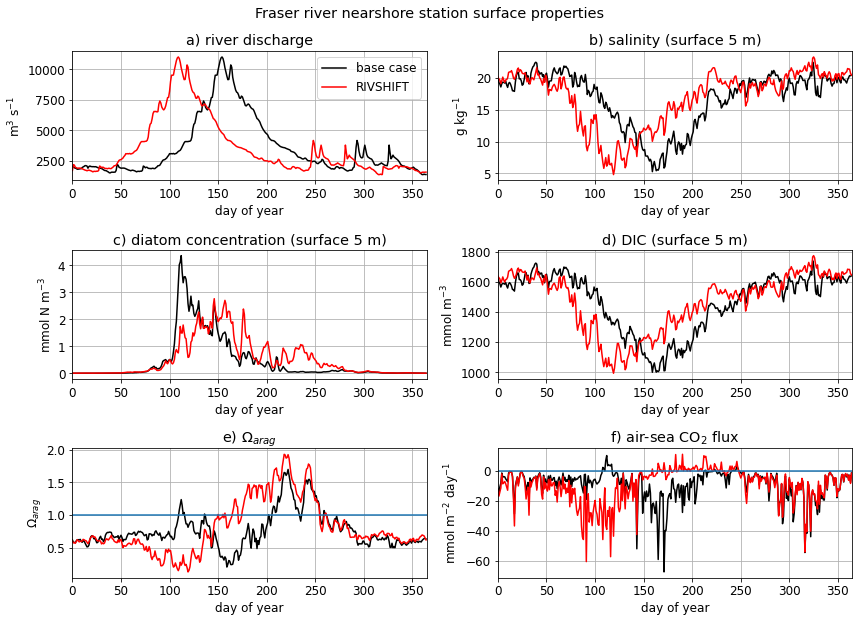

In [28]:
# Fraser_BASE_SHIFT_20170101_20171231.pkl


cols = ['darkgray','red','chocolate','tan','orange',\
    'navy','palegreen','mediumaquamarine','dodgerblue','violet']
wsl = ['Howe', 'Juan de Fuca', 'Puget', 'Skagit', 'Fraser', 'North Vancouver Island', 
          'Jervis', 'Toba', 'Bute', 'South Vancouver Island']
watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']


plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 12}
# i = 0 
# for w in watersheds:
#     interp_clim = climatology_file[w][:]
#     plt.plot(interp_clim, color = cols[i], label = wsl[i])
#     i = i+1
fact = 1.1
fig, axs = plt.subplots(3,2, figsize=(11*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

wat_to_rot = ['skagit', 'howe', 'bute', 'toba']

ftot = (np.sum(clim_dict['fraser']['Fraser']['interp_clim']))
# howe = np.sum(climatology_file['howe'])
# skagit = np.sum(climatology_file['skagit'])
# toba = np.sum(climatology_file['toba'])
# bute = np.sum(climatology_file['bute'])
# jervis = np.sum(climatology_file['jervis'])
# puget = np.sum(climatology_file['puget'])
# jdf = np.sum(climatology_file['jdf'])
# evi_s = np.sum(climatology_file['evi_s'])
# evi_n = np.sum(climatology_file['evi_n'])

axs[0].plot(clim_dict['fraser']['Fraser']['interp_clim'], color = 'k', label = 'base case')
axs[0].plot(np.roll(clim_dict['fraser']['Fraser']['interp_clim'],-45), color = 'r', linestyle = '-', label = 'RIVSHIFT')
axs[0].set_ylabel('m$^{3}$ s$^{-1}$')

axs[1].plot(Fraser_base['sal_rad10'], color = 'k')
axs[1].plot(Fraser_shift['sal_rad10'], color = 'r')
axs[1].set_ylabel('g kg$^{-1}$')

axs[2].plot(Fraser_base['diat_rad10'], color = 'k')
axs[2].plot(Fraser_shift['diat_rad10'], color = 'r')
axs[2].set_ylabel('mmol N m$^{-3}$')

axs[3].plot(Fraser_base['DIC_rad10'], color = 'k')
axs[3].plot(Fraser_shift['DIC_rad10'], color = 'r')
axs[3].set_ylabel('mmol m$^{-3}$')

 

sal_r = np.ravel(Fraser_base['sal_rad10'])
temp_r = np.ravel(Fraser_base['temp_rad10'])
tzero = np.zeros_like(sal_r)
DIC_r = np.ravel(Fraser_base['DIC_rad10'])
TA_r = np.ravel(Fraser_base['TA_rad10'])
tpressure = tzero+1
tsra_psu = sal_r*35/35.16504
ttera_is = gsw.t_from_CT(sal_r,temp_r,tzero)

response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=TA_r*1e-3, dic=DIC_r*1e-3, 
                   sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                    optcon='mol/m3', optt='Tinsitu', optp='m',
                    optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH,pco2_mod,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
oma_base = OmegaA

sal_r = np.ravel(Fraser_shift['sal_rad10'])
temp_r = np.ravel(Fraser_shift['temp_rad10'])
tzero = np.zeros_like(sal_r)
DIC_r = np.ravel(Fraser_shift['DIC_rad10'])
TA_r = np.ravel(Fraser_shift['TA_rad10'])
tpressure = tzero+1
tsra_psu = sal_r*35/35.16504
ttera_is = gsw.t_from_CT(sal_r,temp_r,tzero)

response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=TA_r*1e-3, dic=DIC_r*1e-3, 
                   sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                    optcon='mol/m3', optt='Tinsitu', optp='m',
                    optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH,pco2_mod,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
oma_shift = OmegaA
axs[4].plot(oma_base, color = 'k')
axs[4].plot(oma_shift, color = 'r')
axs[4].set_ylabel('$\Omega_{arag}$')
axs[4].axhline(y=1)

sid = 60*60*24
axs[5].plot(Fraser_base['co2flux_rad10']*sid, color = 'k')
axs[5].plot(Fraser_shift['co2flux_rad10']*sid, color = 'r')
axs[5].set_ylabel('mmol m$^{-2}$ day$^{-1}$')
axs[5].axhline(y=0)

for i in range(0,6):
    axs[i].grid(); axs[i].set_xlim([0,365]); 
    axs[i].set_xlabel('day of year');
    
axs[0].set_title('a) river discharge')
axs[1].set_title('b) salinity (surface 5 m)')   
axs[2].set_title('c) diatom concentration (surface 5 m)') 
axs[3].set_title('d) DIC (surface 5 m)') 
axs[4].set_title('e) $\Omega_{arag}$') 
axs[5].set_title('f) air-sea CO$_2$ flux') 
axs[0].legend()
plt.suptitle('Fraser river nearshore station surface properties')
plt.tight_layout()

[19.07644844 25.33648872 26.71810341 26.26612473 21.51864243 19.54393768
 19.04656792 20.10328674 20.13175774 17.90192413 22.59549713 21.59503555
 19.93681717 20.65087128 20.60530663 19.75403023 18.55920601 15.60797405
 15.23966694 15.95063686 18.17409515 18.8584156  19.40577316 19.66213608
 18.98965454 18.42321205 18.22874451 16.76557732 15.86471462 14.62069702
 18.31713676 24.4470253  26.00474167 24.83002663 21.87900352 21.46402931
 22.62602997 22.93228722 22.68006134 23.36550713 20.21528053 18.08632278
 18.55770111 20.47087097 20.40106392 18.76208878 14.95425987 14.53199387
 18.01576805 18.66506577 14.72881508 14.69766045 16.08887482 16.06835747
 16.63212776 16.4011898  16.09158897 20.93771362 19.48081207 15.10004044
 14.74053955 10.76412201 12.58702087 18.00234795 18.21236992 13.35386753
 11.58586407 15.59772301 17.53985596 16.37217331 16.18383598 14.55701923
 17.5550251  15.86750412 12.55144119 10.03752613 13.90309334 11.09779263
 17.18614006 22.43165398 21.91799927 12.78491211 13

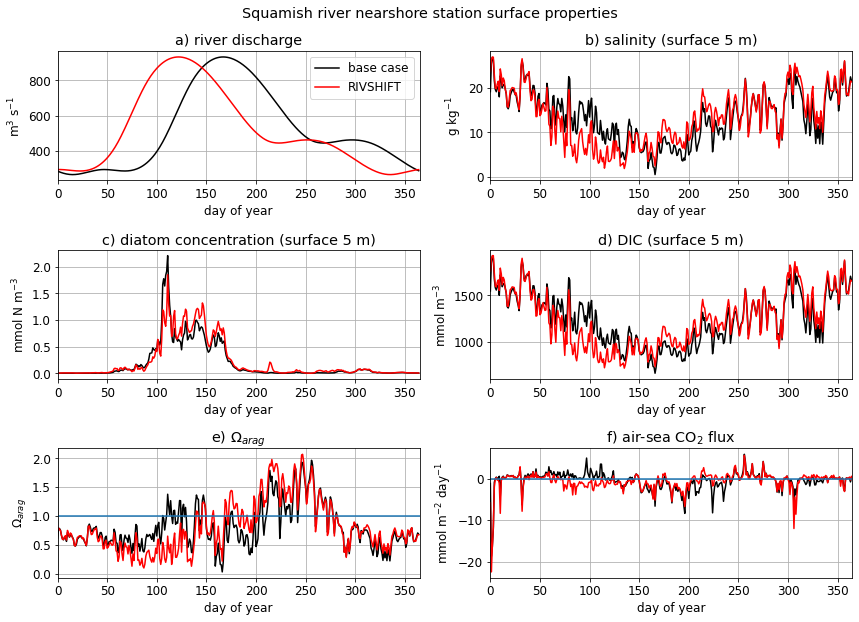

In [30]:
# Squamish_BASE_SHIFT_20170101_20171231.pkl
Squamish_base = pickle.load(open('./Squamish_BASE_SHIFT_20170101_20171231.pkl', 'rb'))
Squamish_shift = pickle.load(open('./Squamish_RIV3_SHIFT_20170101_20171231.pkl', 'rb'))

print(Squamish_base['sal_rad10'])

cols = ['darkgray','red','chocolate','tan','orange',\
    'navy','palegreen','mediumaquamarine','dodgerblue','violet']
wsl = ['Howe', 'Juan de Fuca', 'Puget', 'Skagit', 'Squamish', 'North Vancouver Island', 
          'Jervis', 'Toba', 'Bute', 'South Vancouver Island']
watersheds = ['howe', 'jdf', 'puget', 'skagit', 'Squamish', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']


plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 12}
# i = 0 
# for w in watersheds:
#     interp_clim = climatology_file[w][:]
#     plt.plot(interp_clim, color = cols[i], label = wsl[i])
#     i = i+1
fact = 1.1
fig, axs = plt.subplots(3,2, figsize=(11*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

wat_to_rot = ['skagit', 'howe', 'bute', 'toba']

ftot = (np.sum(clim_dict['howe']['Squamish']['interp_clim']))
# howe = np.sum(climatology_file['howe'])
# skagit = np.sum(climatology_file['skagit'])
# toba = np.sum(climatology_file['toba'])
# bute = np.sum(climatology_file['bute'])
# jervis = np.sum(climatology_file['jervis'])
# puget = np.sum(climatology_file['puget'])
# jdf = np.sum(climatology_file['jdf'])
# evi_s = np.sum(climatology_file['evi_s'])
# evi_n = np.sum(climatology_file['evi_n'])

axs[0].plot(clim_dict['howe']['Squamish']['interp_clim'], color = 'k', label = 'base case')
axs[0].plot(np.roll(clim_dict['howe']['Squamish']['interp_clim'],-45), color = 'r', linestyle = '-', label = 'RIVSHIFT')
axs[0].legend()

axs[0].set_ylabel('m$^{3}$ s$^{-1}$')

axs[1].plot(Squamish_base['sal_rad10'], color = 'k')
axs[1].plot(Squamish_shift['sal_rad10'], color = 'r')
axs[1].set_ylabel('g kg$^{-1}$')

axs[2].plot(Squamish_base['diat_rad10'], color = 'k')
axs[2].plot(Squamish_shift['diat_rad10'], color = 'r')
axs[2].set_ylabel('mmol N m$^{-3}$')

axs[3].plot(Squamish_base['DIC_rad10'], color = 'k')
axs[3].plot(Squamish_shift['DIC_rad10'], color = 'r')
axs[3].set_ylabel('mmol m$^{-3}$')

 

sal_r = np.ravel(Squamish_base['sal_rad10'])
temp_r = np.ravel(Squamish_base['temp_rad10'])
tzero = np.zeros_like(sal_r)
DIC_r = np.ravel(Squamish_base['DIC_rad10'])
TA_r = np.ravel(Squamish_base['TA_rad10'])
tpressure = tzero+1
tsra_psu = sal_r*35/35.16504
ttera_is = gsw.t_from_CT(sal_r,temp_r,tzero)

response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=TA_r*1e-3, dic=DIC_r*1e-3, 
                   sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                    optcon='mol/m3', optt='Tinsitu', optp='m',
                    optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH,pco2_mod,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
oma_base = OmegaA

sal_r = np.ravel(Squamish_shift['sal_rad10'])
temp_r = np.ravel(Squamish_shift['temp_rad10'])
tzero = np.zeros_like(sal_r)
DIC_r = np.ravel(Squamish_shift['DIC_rad10'])
TA_r = np.ravel(Squamish_shift['TA_rad10'])
tpressure = tzero+1
tsra_psu = sal_r*35/35.16504
ttera_is = gsw.t_from_CT(sal_r,temp_r,tzero)

response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=TA_r*1e-3, dic=DIC_r*1e-3, 
                   sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                    optcon='mol/m3', optt='Tinsitu', optp='m',
                    optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH,pco2_mod,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
oma_shift = OmegaA
axs[4].plot(oma_base, color = 'k')
axs[4].plot(oma_shift, color = 'r')
axs[4].set_ylabel('$\Omega_{arag}$')
axs[4].axhline(y=1)

sid = 60*60*24
axs[5].plot(Squamish_base['co2flux_rad10']*sid, color = 'k')
axs[5].plot(Squamish_shift['co2flux_rad10']*sid, color = 'r')
axs[5].set_ylabel('mmol m$^{-2}$ day$^{-1}$')
axs[5].axhline(y=0)

for i in range(0,6):
    axs[i].grid(); axs[i].set_xlim([0,365]); 
    axs[i].set_xlabel('day of year');
    
axs[0].set_title('a) river discharge')
axs[1].set_title('b) salinity (surface 5 m)')   
axs[2].set_title('c) diatom concentration (surface 5 m)') 
axs[3].set_title('d) DIC (surface 5 m)') 
axs[4].set_title('e) $\Omega_{arag}$') 
axs[5].set_title('f) air-sea CO$_2$ flux') 

plt.suptitle('Squamish river nearshore station surface properties')
plt.tight_layout()

[23.36243248 25.01695061 25.67566299 25.99402046 25.48855209 23.74002457
 21.83431625 24.46057701 25.46340179 25.48454094 26.75462914 25.98510933
 24.95872307 24.74684906 24.51621246 23.85916519 21.19657326 19.08213806
 19.1808548  19.55469894 22.91214561 23.90904808 24.58288574 25.04677963
 24.4663868  24.31616402 23.64341164 21.21439552 20.03944397 19.69447517
 23.23469925 25.12183762 26.26008415 26.10694313 26.47986603 27.14896774
 27.49032402 27.63760376 27.63877106 27.39068794 25.43335342 23.09517288
 21.91986465 23.09397125 24.45637512 21.8668499  19.16514206 19.3373661
 22.37326241 23.64796638 23.48190689 21.43279266 21.57679749 22.74142647
 22.73721313 24.5878582  24.18466568 25.77270317 25.39259529 23.21153069
 22.12129784 19.89169502 20.05836868 22.77887535 22.87913132 19.80132484
 20.05342102 21.01205254 23.49450302 22.74310875 20.44248009 19.40321732
 20.56457138 19.43139076 19.40996361 17.23380089 17.72382164 17.13816643
 19.40979195 22.4880352  21.79728317 17.62713432 18.

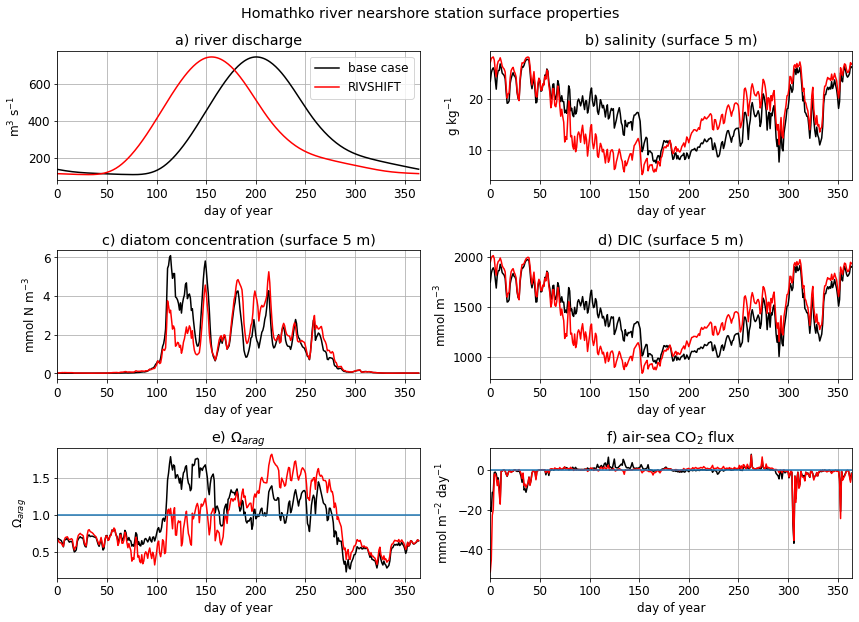

In [31]:
# Homathko_BASE_SHIFT_20170101_20171231.pkl
Homathko_base = pickle.load(open('./Homathko_BASE_SHIFT_20170101_20171231.pkl', 'rb'))
Homathko_shift = pickle.load(open('./Homathko_RIV3_SHIFT_20170101_20171231.pkl', 'rb'))

print(Homathko_base['sal_rad10'])

cols = ['darkgray','red','chocolate','tan','orange',\
    'navy','palegreen','mediumaquamarine','dodgerblue','violet']
wsl = ['Howe', 'Juan de Fuca', 'Puget', 'Skagit', 'Homathko', 'North Vancouver Island', 
          'Jervis', 'Toba', 'Bute', 'South Vancouver Island']
watersheds = ['howe', 'jdf', 'puget', 'skagit', 'Homathko', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']


plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 12}
# i = 0 
# for w in watersheds:
#     interp_clim = climatology_file[w][:]
#     plt.plot(interp_clim, color = cols[i], label = wsl[i])
#     i = i+1
fact = 1.1
fig, axs = plt.subplots(3,2, figsize=(11*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

wat_to_rot = ['skagit', 'howe', 'bute', 'toba']

ftot = (np.sum(clim_dict['bute']['Homathko']['interp_clim']))
# howe = np.sum(climatology_file['howe'])
# skagit = np.sum(climatology_file['skagit'])
# toba = np.sum(climatology_file['toba'])
# bute = np.sum(climatology_file['bute'])
# jervis = np.sum(climatology_file['jervis'])
# puget = np.sum(climatology_file['puget'])
# jdf = np.sum(climatology_file['jdf'])
# evi_s = np.sum(climatology_file['evi_s'])
# evi_n = np.sum(climatology_file['evi_n'])

axs[0].plot(clim_dict['bute']['Homathko']['interp_clim'], color = 'k', label = 'base case' )
axs[0].plot(np.roll(clim_dict['bute']['Homathko']['interp_clim'],-45), color = 'r', linestyle = '-', label = 'RIVSHIFT')
axs[0].set_ylabel('m$^{3}$ s$^{-1}$')
axs[0].legend()

axs[1].plot(Homathko_base['sal_rad10'], color = 'k')
axs[1].plot(Homathko_shift['sal_rad10'], color = 'r')
axs[1].set_ylabel('g kg$^{-1}$')

axs[2].plot(Homathko_base['diat_rad10'], color = 'k')
axs[2].plot(Homathko_shift['diat_rad10'], color = 'r')
axs[2].set_ylabel('mmol N m$^{-3}$')

axs[3].plot(Homathko_base['DIC_rad10'], color = 'k')
axs[3].plot(Homathko_shift['DIC_rad10'], color = 'r')
axs[3].set_ylabel('mmol m$^{-3}$')

 

sal_r = np.ravel(Homathko_base['sal_rad10'])
temp_r = np.ravel(Homathko_base['temp_rad10'])
tzero = np.zeros_like(sal_r)
DIC_r = np.ravel(Homathko_base['DIC_rad10'])
TA_r = np.ravel(Homathko_base['TA_rad10'])
tpressure = tzero+1
tsra_psu = sal_r*35/35.16504
ttera_is = gsw.t_from_CT(sal_r,temp_r,tzero)

response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=TA_r*1e-3, dic=DIC_r*1e-3, 
                   sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                    optcon='mol/m3', optt='Tinsitu', optp='m',
                    optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH,pco2_mod,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
oma_base = OmegaA

sal_r = np.ravel(Homathko_shift['sal_rad10'])
temp_r = np.ravel(Homathko_shift['temp_rad10'])
tzero = np.zeros_like(sal_r)
DIC_r = np.ravel(Homathko_shift['DIC_rad10'])
TA_r = np.ravel(Homathko_shift['TA_rad10'])
tpressure = tzero+1
tsra_psu = sal_r*35/35.16504
ttera_is = gsw.t_from_CT(sal_r,temp_r,tzero)

response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=TA_r*1e-3, dic=DIC_r*1e-3, 
                   sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                    optcon='mol/m3', optt='Tinsitu', optp='m',
                    optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH,pco2_mod,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
oma_shift = OmegaA
axs[4].plot(oma_base, color = 'k')
axs[4].plot(oma_shift, color = 'r')
axs[4].set_ylabel('$\Omega_{arag}$')
axs[4].axhline(y=1)

sid = 60*60*24
axs[5].plot(Homathko_base['co2flux_rad10']*sid, color = 'k')
axs[5].plot(Homathko_shift['co2flux_rad10']*sid, color = 'r')
axs[5].set_ylabel('mmol m$^{-2}$ day$^{-1}$')
axs[5].axhline(y=0)

for i in range(0,6):
    axs[i].grid(); axs[i].set_xlim([0,365]); 
    axs[i].set_xlabel('day of year');
    
axs[0].set_title('a) river discharge')
axs[1].set_title('b) salinity (surface 5 m)')   
axs[2].set_title('c) diatom concentration (surface 5 m)') 
axs[3].set_title('d) DIC (surface 5 m)') 
axs[4].set_title('e) $\Omega_{arag}$') 
axs[5].set_title('f) air-sea CO$_2$ flux') 

plt.suptitle('Homathko river nearshore station surface properties')
plt.tight_layout()